In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

DATA_PATH = os.getenv('TEACHER_DIR', os.getcwd()) + '/JHL_data'

# Introduction to Deep Learning with PyTorch

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building a toy model for classifying handwritten numbers with accuracies surpassing 95%. This model will be a basic fully-connected neural network.

### The Task for the Neural Network

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. 

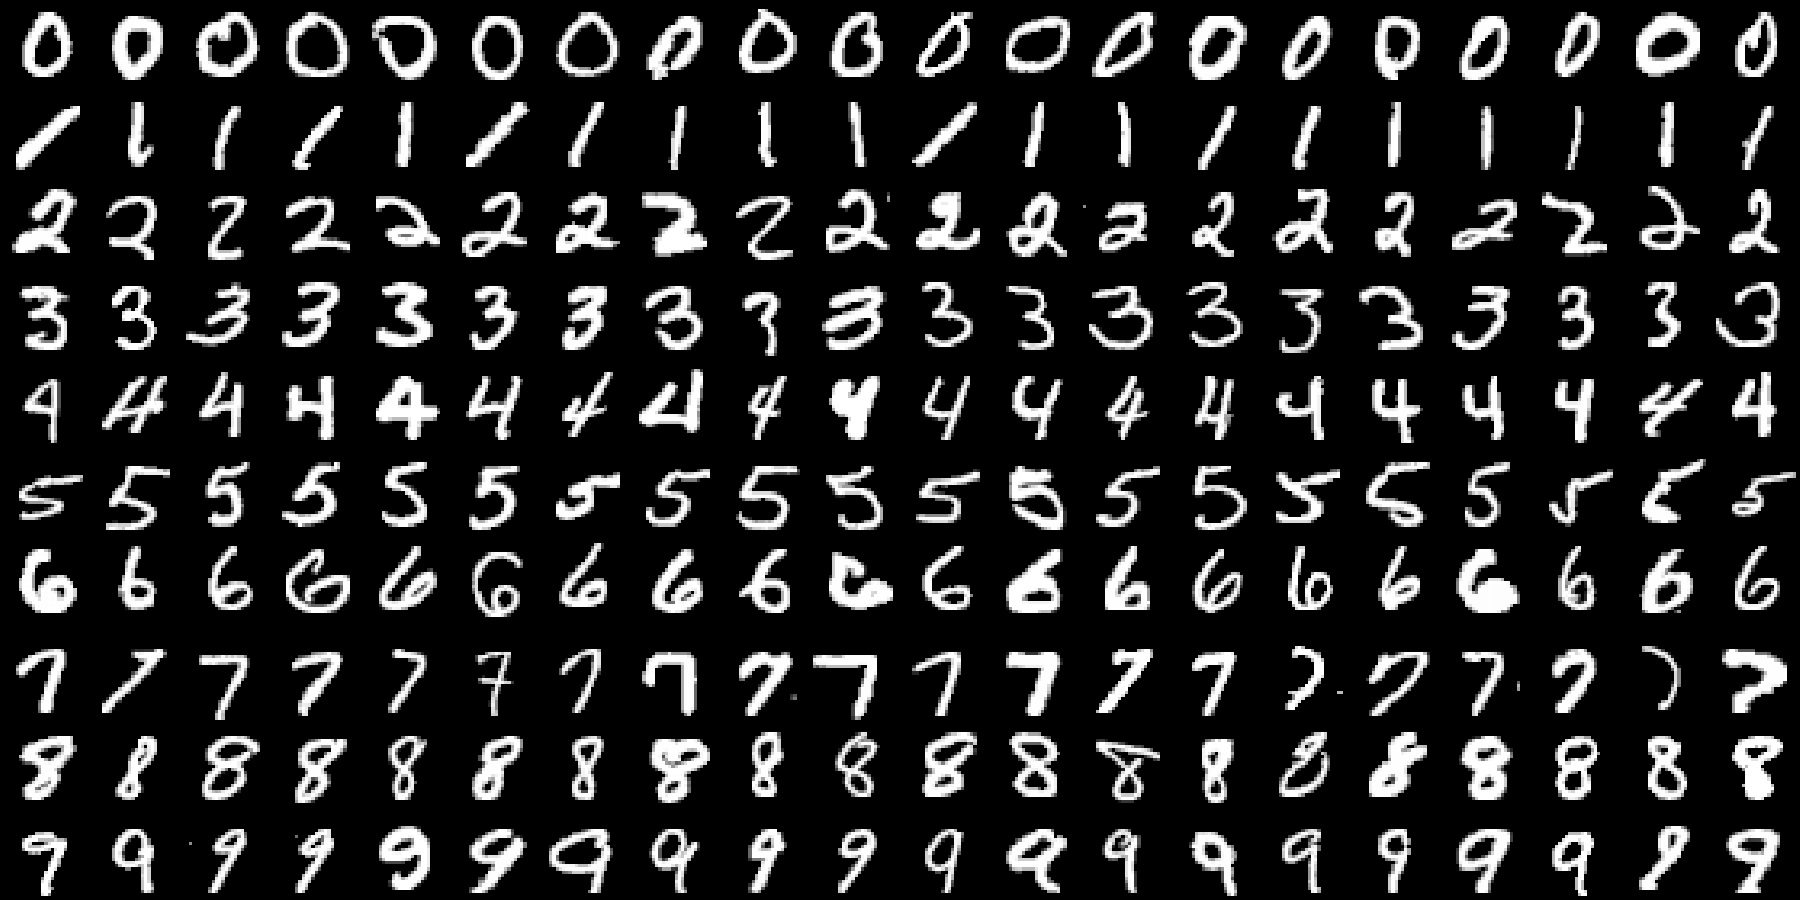


## Loading Training Data

The MNIST dataset is conveniently bundled within Torch Vision, and we can easily take a look at some of its features.

### Lets take a look at our input data

In [ ]:
example_trainset = datasets.MNIST(DATA_PATH, train=True, transform=transforms.ToTensor())

example_image, example_label = next(iter(example_trainset))

print(f"Input data shape: {example_image.shape}")
example_image = example_image[0] # removing first dimension

print(f"Input label: {example_label}")

%matplotlib inline
plt.imshow(example_image, cmap='gray')
plt.show()

### Let's plot the numerical representation of the image so that we can see what the model sees as input!

In [ ]:
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(example_image, cmap='gray')
width, height = example_image.shape
thresh = example_image.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(example_image[x][y].item(), 2) if example_image[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if example_image[x][y]<thresh else 'black')

Formatting the input data layer
Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector.

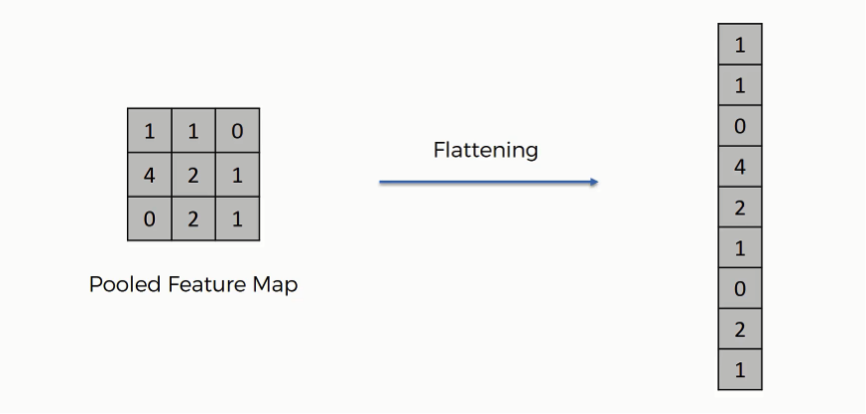

This will be the first layer to the model we are going to build.

# Building the model

We will build the following model:  
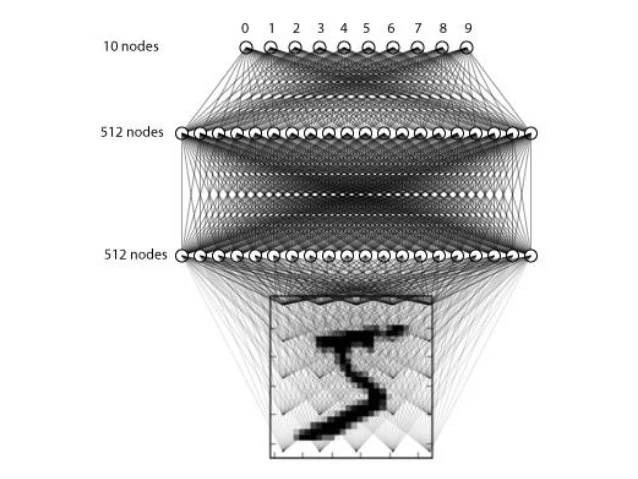

To represent a model in PyTorch, you usually extend PyTorch's nn.Module class.
There, we define our layers, and in its instance method _forward_, we define what happens when our model receives some input.

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()  # Python magic which initialises all relevant PyTorch properties
        
        # Here, define your model!
        # We are going to need:
        # - A layer that flattens the input
        # - A fully connected layer which has 512 neurons who each connect to the full 28x28 input
        # - A non linear activation layer
        # - A fully connected layer which has 512 neurons who each connect to the 512 previous neurons
        # - A non-linear activation layer
        # - A fully connected layer which has 10 neurons, each of which represent an output class,
        #   which each connect to the previous 512 neurons
        # - A log softmax layer which converts the 'unbounded' activations to the domain [-inf, 0]
        #   (log softmax is numerically more stable than a regular softmax)
        #   (why we use the softmax in any case instead of simply normalizing the output is a difficult question,
        #    see Bishop 2006)
        
        self.flatten = ...
        self.fully_connected1 = ...
        sef.relu1 = ...
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.fully_connected1(x)
        x = self.relu1(x)
        
        # --- Fill in the rest! ---
        x = ...
        return x

### What we want to do to train this model; gradient descent:
Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution.

he optimizer helps determine how quickly the model learns through gradient descent. The rate at which descends a gradient is called the learning rate.

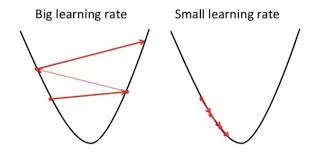

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

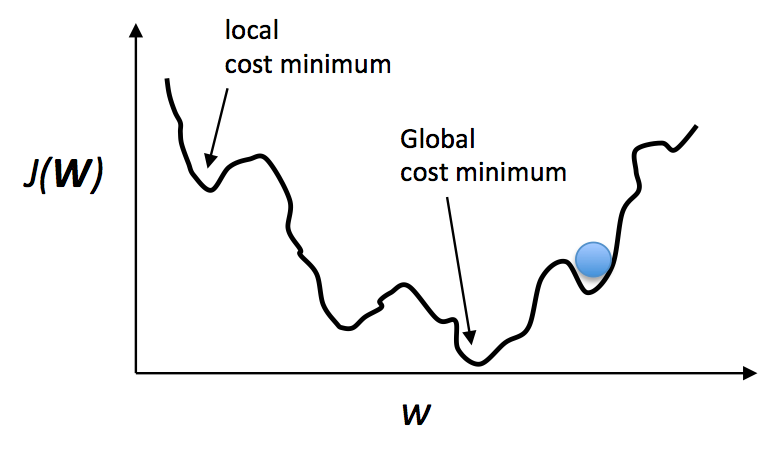

Although this image is not entirely correct: it doesn't exist in reality.
Loss manifolds are complicated...but let's not think about that too hard right now, instead:


### What we need to train this model under the hood...
- The calculation and retention of computational graphs when you call model.forward()
- The calculation of gradients when we calculate the loss and call loss.backwards()
- The updating of model parameters when we call optimizer.step()

#### For some slight inspiration, you can (optionally) look at the test loop below
#### For the code below, you only need to use the variables model and optimizer!

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # - set optimizer gradients to zero
        # - call model to get predictions
        output = ...
        # - calculate loss (hint: F.nll_loss):
        loss = ...
        # - backprop the loss
        # - optimizer step

        if batch_idx % log_interval == 0:
            pred = output.argmax(dim=1, keepdim=True) 
            correct = pred.eq(target.view_as(pred)).sum().item()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                correct/len(data)
            ))

### We provide the test loop

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # get model output
            output = model(data)
            
            # calculate loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            
            # get most likely class label
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            # count the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))


### Training hyperparameters and PyTorch boilerplate

In [ ]:
use_cuda = torch.cuda.is_available()
print(f"CUDA is {'' if use_cuda else 'not '}available")
device = torch.device("cuda" if use_cuda else "cpu")

### Training the model

This is the fun part!

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation.
Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size reduces the variance of the update step, which may not always be useful for succesfully training the model due to underfitting. 

Too small of a batch size increases the variance of the update step, which may lead the optimizer to miss the global minimum.

So a good batch size may take some trial and error to find (or hyperparameter optimization...)!

In [ ]:
BATCH_SIZE = ...
EPOCHS = ...
LEARNING_RATE = ...
LOG_INTERVAL = 10

model = FCNN().to(device)
optimizer = ... # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)


transform = transforms.Compose([
    transforms.ToTensor(), # Creates the PyTorch tensors from the PIL images, and normalizes them to the [0, 1] interval 
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizes the data to 0 mean and 1 standard deviation
])

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.MNIST(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=train
    )
    for train in (True, False)
)

model = model.to(device)

for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch, LOG_INTERVAL)
    test(model, device, test_loader)

### (Hopefully) your loss goes down, and your accuracy goes up!

Don't be dissuaded if your model doesn't train with your first set of hyperparameters, (efficient) hyperparameter optimization is still an unsolved research problem.

